# **Fraud Detection**

In [60]:
# Import Libraries
import pandas as pd
import numpy as np
from datetime import datetime as dt
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
from matplotlib import cm

# Data Preprocessing
from sklearn.model_selection import train_test_split
from feature_engine.outliers import OutlierTrimmer, Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder, OrdinalEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from mlxtend.plotting import plot_confusion_matrix

# Metric
from sklearn.metrics import classification_report, roc_auc_score, auc, RocCurveDisplay, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Deployment
import joblib
import pickle

# from packages.checker import check_unique
# from packages.checker import check_missing, check_missing_special
# from packages.outlier_handling import check_outlier, check_dist, outlier_summary, trim_cap_outliers

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('dataset_fraud_detection.csv')

In [5]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [6]:
# Duplicate Dataset
dataNew = data.copy()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


# **Exploratory Data Analysis**

**Comparison Type**

<AxesSubplot:xlabel='type', ylabel='count'>

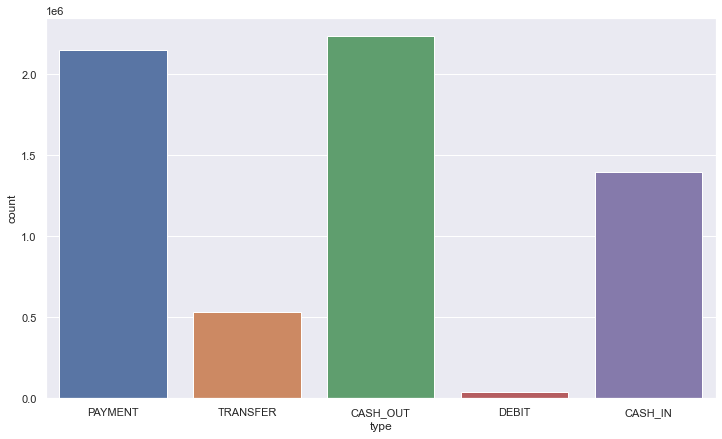

In [10]:
sns.set(rc={'figure.figsize':(12,7)})
sns.countplot(data=data, x='type')

**Amount Highest based on Type**

In [11]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [12]:
dataAmountType = data.groupby('type')[['amount']].mean().reset_index().sort_values('amount', ascending=True)
dataAmountType

,type,amount
2,DEBIT,5483.665314
3,PAYMENT,13057.604660
0,CASH_IN,168920.242004
1,CASH_OUT,176273.964346
4,TRANSFER,910647.009645


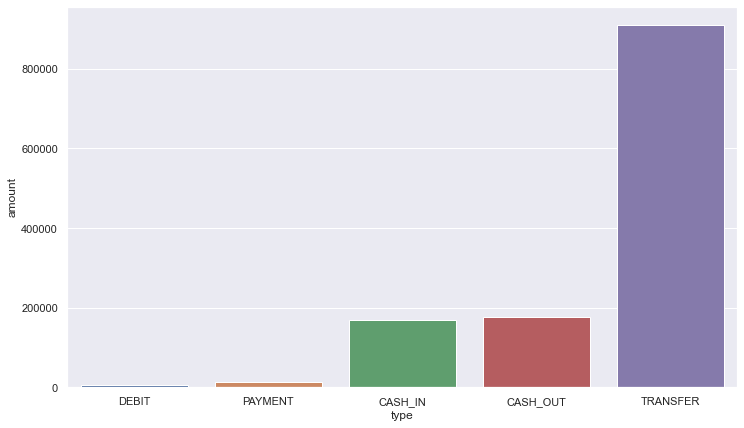

In [13]:
sns.set(rc={'figure.figsize':(12,7)})
sns.barplot(data=dataAmountType, x='type', y='amount')
plt.show()

## **Comparing Target Values dengan type**

In [14]:
# Create function for boxplot
def boxplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.boxplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                data=data, palette="PRGn",showfliers=False)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

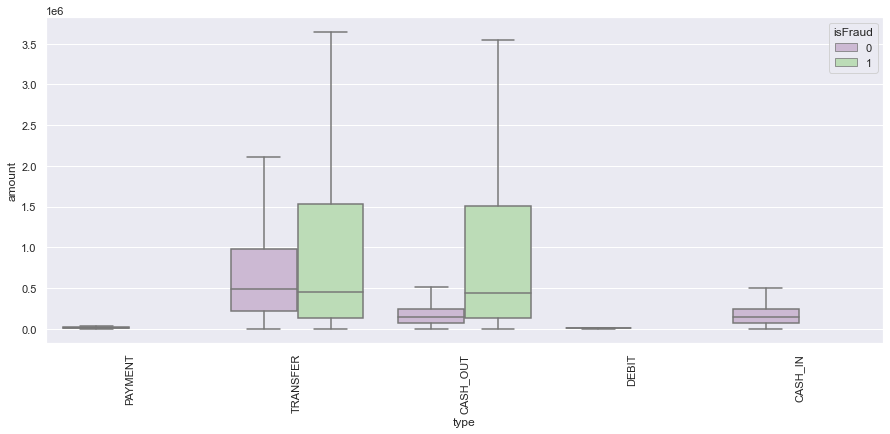

In [15]:
boxplot_variation('type','amount', 'isFraud',15)

## **Comparing Numerical Values**

In [21]:
data.tail(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


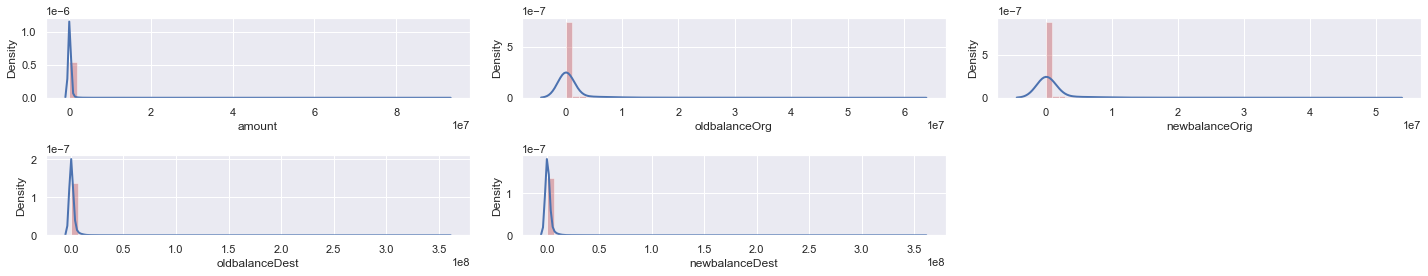

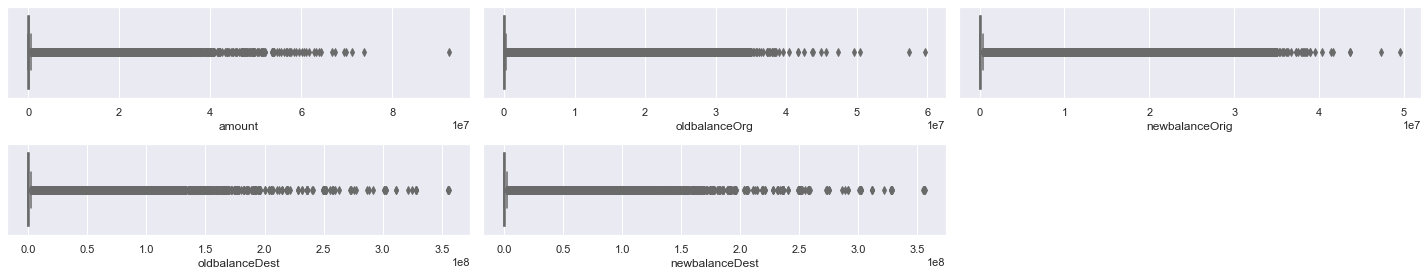

In [30]:
#  Check summary distribution plot and boxplot

warnings.simplefilter(action='ignore', category=FutureWarning)
list_good = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
plt.figure(figsize=(20, 4))
for i in range(len(list_good)):
    plt.subplot(len(list_good)//2, 3, i + 1)
    sns.distplot(data[list_good[i]], kde_kws={'color':'b','bw': 0.5,'lw':2,'label':'KDE'},hist_kws={'color':'r'})
plt.tight_layout()
plt.show()
plt.figure(figsize=(20, 4))
for i in range(len(list_good)):
    plt.subplot(len(list_good)//2, 3, i + 1)
    sns.boxplot(
        x = data[list_good[i]],
        palette="Set3"
    )
plt.tight_layout()
plt.show()

## **Heatmap**

### Checking correlation between each variables

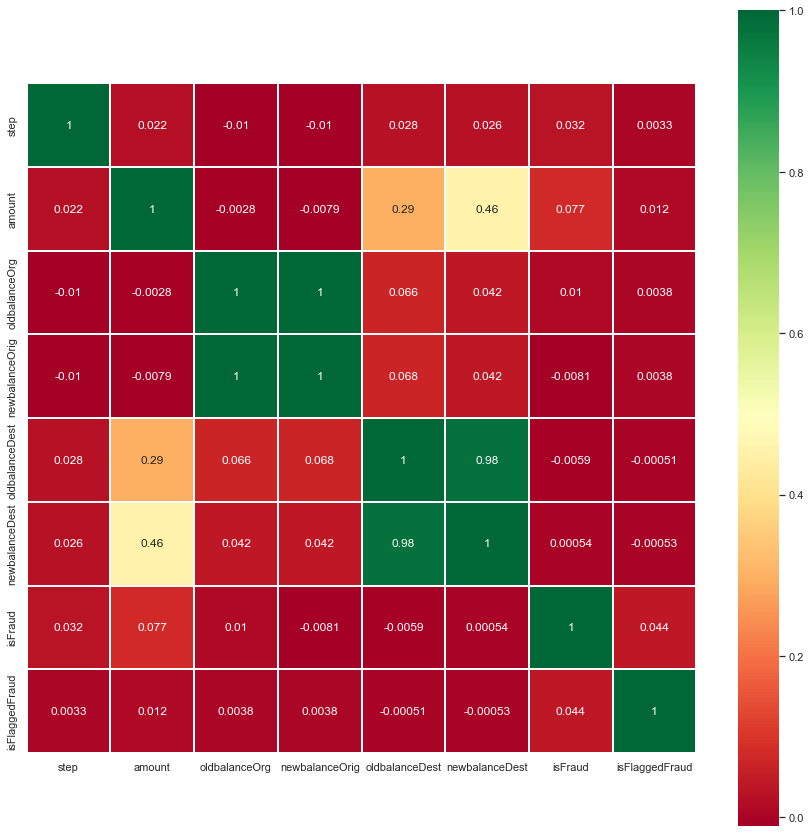

In [18]:
corrmat = data.corr()
top_corr_feature = corrmat.index

plt.figure(figsize=(15,15))

g = sns.heatmap(data[top_corr_feature].corr(), annot=True, cmap='RdYlGn', square=1, linewidths=0.05)

### Checking correlation between target variable and input variables

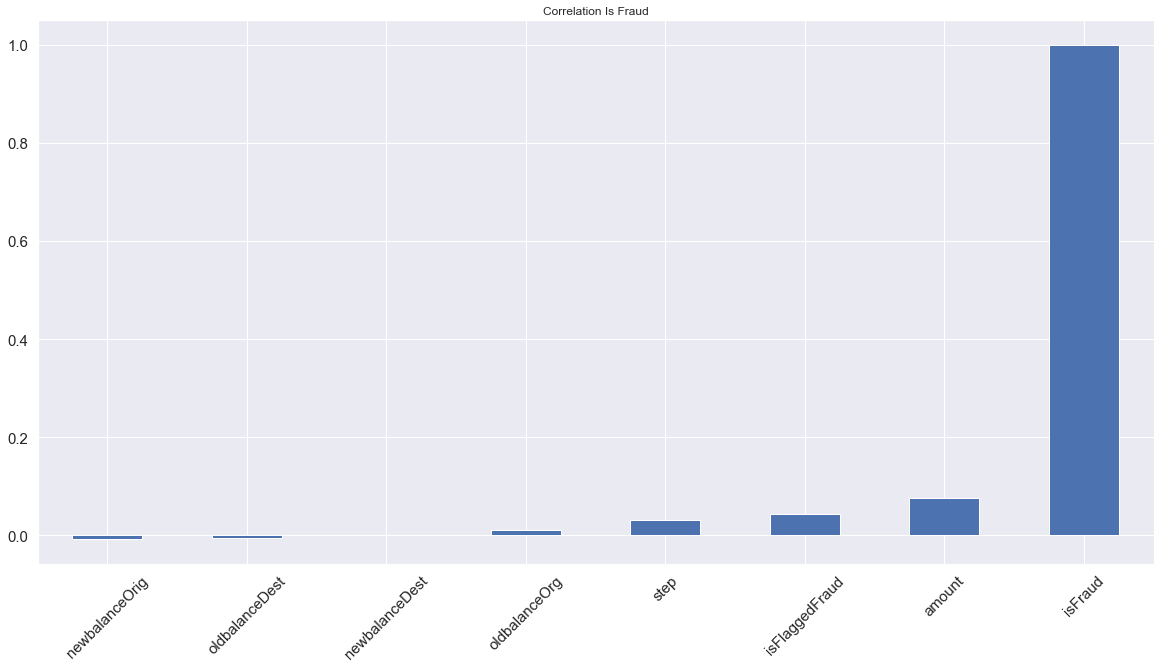

In [19]:
data.corrwith(data['isFraud']).sort_values().plot.bar(figsize=(20,10), title='Correlation Is Fraud', fontsize=15, rot=45, grid=True)
plt.show()

# **Data Preprocessing**

In [31]:
# Set Random State
random_state = 42

In [34]:
# Inference Set Preparation for

inf_set = data.sample(28, random_state=random_state)
inf_set.shape

(28, 11)

In [35]:
# Exclude Inference Set From Dataset

train_set = data.drop(inf_set.index)
train_set.reset_index(drop=True, inplace=True)

train_set.shape

(6362592, 11)

In [37]:
# Splitting dataset for X and y

# X will be consist input parameter only
X = train_set.drop(['isFraud'], axis=1)

# y will be consist target parameter only
y= train_set['isFraud']

In [38]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)


In [39]:
# Size summary

print('Train Set Shape : ', X_train.shape)
print('Test Set Shape : ', X_test.shape)
print('Inference Set Shape : ', inf_set.shape)

Train Set Shape :  (5090073, 10)
Test Set Shape :  (1272519, 10)
Inference Set Shape :  (28, 11)


**Outliers Detection**

In this sub-process, I will try to identify any outliers inside each numerical input variables.

- First, I'll check the distribution of each variable, using skewness value. Any skewness value outside -0.5 to 0.5 will be considered as **Skewed Distribution**, while any skewness value inside -0.5 to 0.5 will be considered as Normal Distribution.
- Second, I'll count how many outliers there in each variable. For **Normal Distribution**, I'll use Z-score to determine the outliers threshold. For Skewed Distribution, I'll use IQR to determine the outliers threshold.
Third Summarize all the information above.

In [40]:
# Column categorization

def col_categorization(df):
    global X_train_num, X_train_cat
    X_train_num = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
    X_train_cat = df[['type']]
    print("Generate 'X_train_num' and 'X_train_cat'")

# column categorization 
col_categorization(X_train)

Generate 'X_train_num' and 'X_train_cat'


In [41]:
# Check numerical categorization
X_train_num.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
5904546,105549.16,0.00,0.00,1141943.88,1247493.04
4345382,199905.72,2808941.88,3008847.60,4066763.23,3866857.51
5415930,2571.72,152651.72,150080.00,0.00,0.00
2636864,35932.38,1783050.82,1818983.19,345666.61,1188780.85
5492073,149502.89,0.00,0.00,303054.91,452557.80


After we splitting each feature from categorization and numerical. Now we need to create a funtion to detect outliers from each feature so we can handle outliers perfectly before we train to our model.

In [42]:
# Create funtion to detect outliers based on distribution
def detect_outliers(df, k=1.5):
    #Create datafram with columns name : feature, distribution, outlier
    global df_outliers
    df_outliers = pd.DataFrame(columns=['col_name','distribution','bottom_limit', 'upper_limit', 'left_tail','right_tail','outliers_count','percentage'])
    #Create loop for each feature
    for i in range(len(df.columns)):
        #Create if statement for each distribution
        if df.iloc[:,i].skew() > -0.5 and df.iloc[:,i].skew() < 0.5 :
            #Count outlier for normal distribution based on Z-Score
            df_outliers.loc[i] = [df.columns[i], # col_name
                                'normal', # distribution,
                                round(stats.zscore(df.iloc[:,i]).min()), # bottom limit
                                round(stats.zscore(df.iloc[:,i]).max()), # upper limit
                                df.iloc[:,i][(stats.zscore(df.iloc[:,i],nan_policy='omit'))<-3].count(), # left_tail
                                df.iloc[:,i][(stats.zscore(df.iloc[:,i],nan_policy='omit'))>3].count(), # right_tail
                                df.iloc[:,i][abs(stats.zscore(df.iloc[:,i],nan_policy='omit'))>3].count(), # outliers_count
                                df.iloc[:,i][abs(stats.zscore(df.iloc[:,i],nan_policy='omit'))>3].count()/len(df.iloc[:,i])*100] # percentage
        else:
            #Count outlier for skew distribution based on iQR
            Q1 = df.iloc[:,i].quantile(0.25)
            Q3 = df.iloc[:,i].quantile(0.75)
            IQR = Q3 - Q1
            df_outliers.loc[i] = [df.columns[i], # col_name
                                'skew', # distribution,
                                round(Q1 - k*IQR), # bottom limit
                                round(Q3 + k*IQR), # upper limit
                                df.iloc[:,i][(df.iloc[:,i]<(Q1 - k*IQR))].count(), # left_tail
                                df.iloc[:,i][(df.iloc[:,i]>(Q3 + k*IQR))].count(), # right_tail
                                df.iloc[:,i][(df.iloc[:,i]<(Q1 - k*IQR))|(df.iloc[:,i]>(Q3 + k*IQR))].count(), # outliers_count
                                df.iloc[:,i][(df.iloc[:,i]<(Q1 - k*IQR))|(df.iloc[:,i]>(Q3 + k*IQR))].count()/len(df.iloc[:,i])*100] # percentage
    print("Generate 'df_outliers'") 


In [43]:
# Outliers Summary
detect_outliers(X_train_num)
df_outliers.sort_values(by='percentage',ascending=False)

Generate 'df_outliers'


,col_name,distribution,bottom_limit,upper_limit,left_tail,right_tail,outliers_count,percentage
1,oldbalanceOrg,skew,-161002,268338,0,889891,889891,17.482873
2,newbalanceOrig,skew,-216518,360864,0,842463,842463,16.551099
3,oldbalanceDest,skew,-1415012,2358353,0,628327,628327,12.344165
4,newbalanceDest,skew,-1668650,2781084,0,590321,590321,11.597496
0,amount,skew,-279548,501642,0,270530,270530,5.314855


let's look there on out dataset mostly has normal distribution because from this we have balance dataset, but there are some skewed distribution that has outliers more than 10%, so we need to handle it first, Here are what I'll do:

- I'll trim any outliers that has outliers percentage below 5%
- I'll cap any outliers that has outliers percentage between 5% to 15%

In [44]:
# Create function to handling outliers
def handling_outliers(exception_list):
   global train_set,y_train, norm_under_5, norm_5to15, skew_under_5, skew_5to15
   exception_list = exception_list

   norm_under_5 = df_outliers[df_outliers['distribution']=='normal'][df_outliers['percentage']<5]['col_name'].tolist()
   norm_5to15 = df_outliers[df_outliers['distribution']=='normal'][df_outliers['percentage']>=5][df_outliers['percentage']<15]['col_name'].tolist()
   skew_under_5 = df_outliers[df_outliers['distribution']=='skew'][df_outliers['percentage']<5]['col_name'].tolist()
   skew_5to15 = df_outliers[df_outliers['distribution']=='skew'][df_outliers['percentage']>=5][df_outliers['percentage']<15]['col_name'].tolist() 

   norm_under_5 = [x for x in norm_under_5 if x not in exception_list]
   norm_5to15 = [x for x in norm_5to15 if x not in exception_list]
   skew_under_5 = [x for x in skew_under_5 if x not in exception_list]
   skew_5to15 = [x for x in skew_5to15 if x not in exception_list]


   custom_list = ['norm_under_5','norm_over_5','skew_under_5','skew_over_5']

   for i in custom_list: 
      if i == 'norm_under_5' and len(norm_under_5)!= 0:
         
         trim_norm = OutlierTrimmer(capping_method='gaussian',
                                    tail='both', # left/right/both
                                    fold=3, # for gaussian 2 or 3
                                    variables=norm_under_5,
                                    missing_values='ignore')    
         trim_norm.fit(train_set)

         df = trim_norm.transform(train_set)
         
         # #intersection of y_train and train_set index location
         y_train = y_train.loc[y_train.index.intersection(train_set.index)]

      elif i == 'norm_over_5' and len(norm_5to15)!= 0:

         winsorizer_norm = Winsorizer(capping_method='gaussian',
                                    tail='both', # left/right/both
                                    fold=3, # for gaussian 2 or 3
                                    variables=norm_5to15,
                                    missing_values='ignore')    
         winsorizer_norm.fit(train_set)

         train_set = winsorizer_norm.transform(train_set)
       
   
      elif i == 'skew_under_5'and len(skew_under_5)!= 0:
         
         trim_skew = OutlierTrimmer(capping_method='iqr',
                                    tail='both', # left/right/both
                                    fold=1.5, # for iqr 1 or 2
                                    variables=skew_under_5,
                                    missing_values='ignore')    
         trim_skew.fit(train_set)

         train_set = trim_skew.transform(train_set)

         # #intersection of y_train and train_set
         y_train = y_train.loc[y_train.index.intersection(train_set.index)]
   
      elif i == 'skew_over_5' and len(skew_5to15)!= 0:

         winsorizer_skew = Winsorizer(capping_method='iqr',
                                    tail='both', # left/right/both
                                    fold=1.5, # for iqr 1 or 2
                                    variables=skew_5to15,
                                    missing_values='ignore')    
         winsorizer_skew.fit(train_set)

         train_set = winsorizer_skew.transform(train_set)

In [45]:
# Outliers Handling Summary
print('X_train Before', X_train.shape)
print('y_train Before', y_train.shape)
print('X_train After', X_train.shape)
print('y_train After', y_train.shape)

X_train Before (5090073, 10)
y_train Before (5090073,)
X_train After (5090073, 10)
y_train After (5090073,)


**Missing Value Detection**

In [46]:
# create function to detect missing values

def detect_missval(df):
    global df_missval
    df_missval = pd.DataFrame(columns=['col_name','missing_count','missing_percentage'])
    for i in range(len(df.columns)):
        if df.iloc[:,i].isnull().sum() != 0:
            df_missval.loc[i] = [df.columns[i], # col_name
                                df.iloc[:,i].isnull().sum(), # missing_count
                                df.iloc[:,i].isnull().sum()/len(df.iloc[:,i])*100] # missing_percentage
    print('Generate df_missval')
    return df_missval

In [47]:
# Missing Value check
# X_train Set
detect_missval(X_train)

Generate df_missval


,col_name,missing_count,missing_percentage


**Feature Engineering**

In [48]:
# Column Categorization
cat_nominal = ['type']
num_skew = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Combines three categoy into one
final_features = cat_nominal + num_skew

In [49]:
# Use selected variables
X_train = X_train[final_features]
X_test = X_test[final_features]

In [50]:
# Splitting Dataset based on input type

X_train_cat = X_train[cat_nominal]
X_train_num_skew = X_train[num_skew]

X_test_cat = X_test[cat_nominal]
X_test_num_skew = X_test[num_skew]

**Feature Scaling**

In [51]:
# Define the scaling method
scaler_mm = MinMaxScaler()

# Train the data into scaler
# Use only data from 'Train Set' for training
scaler_mm.fit(X_train_num_skew)

# Transform the input value for each input parameter
# Transform both 'Train Set' and 'Test
# StandardScaler Method


# MinMaxScaler Method
X_train_num_mm = scaler_mm.transform(X_train_num_skew)
X_test_num_mm = scaler_mm.transform(X_test_num_skew)

**Feature Encoding**

In [52]:
# Define the encoding method
encoder = OneHotEncoder()

# Train the data into encoder 
# Use only data from 'Train Set' for training
encoder.fit(X_train_cat)

# Transform the input value for each input parameter
# Transform both 'Train Set' and 'Test Set'
X_train_cat_encoded = encoder.transform(X_train_cat).toarray()
X_test_cat_encoded = encoder.transform(X_test_cat).toarray()

**Concatenate Data**

In [53]:
# Concatenate Numerical MinMaxScaler & StandardScaler

# Concateanate Categorical & Numerical

X_train_final = np.concatenate([X_train_num_mm, X_train_cat_encoded], axis = 1)
X_test_final = np.concatenate([X_test_num_mm, X_test_cat_encoded], axis = 1)

In [54]:
# Make the Feature Engineering Pipeline
pipe_FE = ColumnTransformer([
    ('OHE', OneHotEncoder(), cat_nominal),
    ('MinMaxScaler', MinMaxScaler(), num_skew)
]) 

In [55]:
# Turn it into dataframe

df_X_train_final = pd.DataFrame(X_train_final)
df_X_train_final.sample(10)

,0,1,2,3,4,5,6,7,8,9
1498862,0.000042,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
494451,0.000159,0.001172,0.001112,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
1669166,0.000077,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
3401930,0.000074,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
4733362,0.000376,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
384370,0.001652,0.002695,0.000159,0.028779,0.029194,0.0,1.0,0.0,0.0,0.0
247392,0.000225,0.000589,0.000288,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
3244438,0.000503,0.000092,0.000000,0.051845,0.051952,0.0,0.0,0.0,0.0,1.0
1049142,0.000108,0.000093,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
4555653,0.005503,0.000000,0.000000,0.002558,0.003985,0.0,0.0,0.0,0.0,1.0


In [56]:
# Check the shape of the dataframe after splitting and feature engineering
print(df_X_train_final.shape)

(5090073, 10)


## Model

**Random Forest Algorithm**

In [57]:
# Initial Model
RF = RandomForestClassifier(random_state=random_state, n_jobs=-1, verbose=1)

# Model Pipeline
pipe_RF = Pipeline([
    ('preprocessing', pipe_FE),
    ('RF', RF)
])

# Hyper parameter
params_RF = {
    'RF__criterion': ['gini', 'entropy'],
    'RF__min_samples_split': [2, 4, 8, 16, 32, 64],
    'RF__max_features': ['auto', 'sqrt', 'log2']
}

**AdaBoost**

In [61]:
# Initial Model
Ada = AdaBoostClassifier(random_state=random_state)

# Model Pipeline
pipe_Ada = Pipeline([
    ('preprocessing', pipe_FE),
    ('Ada', Ada)
])

# Hyper parameter
params_Ada = {
    'Ada__n_estimators': [10, 50, 100, 200, 500],
    'Ada__learning_rate': [0.1, 0.5, 1, 10, 50, 100],
    'Ada__algorithm': ['SAMME', 'SAMME.R']
}

**XGBoost**

In [58]:
# Initial Model
XGB = XGBClassifier()

# Model Pipeline
pipe_XGB = imbPipeline([
    ('preprocessing', pipe_FE),
    ('XGB', XGB)
])

# Hyper parameter
params_XGB = {
    'XGB__n_estimators': [100,500, 1000],
    'XGB__eta': [0.1, 0.05, 0.01],
    'XGB__max_depth': [2, 3, 5, 10],
    'XGB__min_child_weight': [1, 2, 3, 4 ,5],
}

**Model Training**

In [62]:
# Cross-validate base model

# prepare models and put it into list
models = []
models.append(('RF', pipe_RF))
models.append(('Ada', pipe_Ada))
models.append(('XGB', pipe_XGB))

# Create empty list to stores result
names = []
results = []
mean_score = []
stdev_score = []

# Cross-validate each model
for name, model in models:
    model.fit(X_train,y_train)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=5, n_jobs=-1)

    names.append(name)
    results.append(scores)
    mean_score.append(round(np.mean(scores),4))
    stdev_score.append(round(np.std(scores),4))

cv_result = pd.DataFrame({'models':names, 'mean_score':mean_score, 'stdev_score':stdev_score})

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
